In [ ]:
"""All TODO"""
# TODO: Add ground-truth data stations as different shape / colour nodes

Imports

In [ ]:
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from datetime import datetime
from pyproj import Transformer
from shapely.geometry import box

Mesh building function definition

In [ ]:
def build_mesh(shape_filepath, grid_resolution=1000):
    """
    Builds a spatial mesh of nodes (centroids of grid cells) within the input catchment boundary.

    Args:
        shape_filepath (str): Path to the catchment boundary shapefile.
        grid_resolution (int): Resolution of the grid (default 1 km resolution, EPSG:27700 is in meters).

    Returns:
        tuple: (mesh_nodes_table_df, mesh_nodes_gdf)
            - mesh_nodes_table_df (pd.DataFrame): Node ID and coordinates.
            - mesh_nodes_gdf (gpd.GeoDataFrame): Node ID, coordinates, and geometry (Point).
    """
    # Load spatial boundary shape file
    catchment_polygon = gpd.read_file(shape_filepath)
    catchment_polygon = catchment_polygon.to_crs(epsg=27700) # Convert to British National Grid

    # Check polygon geometry -> if shapefile has multiple features then dissolve them
    if len(catchment_polygon) > 1:
        print("\nMultiple polygons found in the catchment boundary. Merging into a single geometry.")
        catchment_geometry = catchment_polygon.unary_union
    else:
        print("\nSingle polygon found in the catchment boundary.")
        catchment_geometry = catchment_polygon.geometry.iloc[0]

    # Get the bounds of the catchment and set grid resolution (in km)
    minx, miny, maxx, maxy = catchment_polygon.total_bounds
    print(f"Catchment bounding box: min_x={minx}, min_y={miny}, max_x={maxx}, max_y={maxy}")
    
    ## ---- Set up coordinate node mesh ----

    # Generate bottom left coordinates of grid cells
    x_coordinates_bottomleft = np.arange(minx, maxx + grid_resolution, grid_resolution)
    y_coordinates_bottomleft = np.arange(miny, maxy + grid_resolution, grid_resolution)

    print(f"\nNumber of x-coordinates (bottom-left): {len(x_coordinates_bottomleft)}")
    print(f"Number of y-coordinates (bottom-left): {len(y_coordinates_bottomleft)}")

    # Initialise grid cell list and set up regular grid of points within the bounding box
    grid_cells = []
    for x in x_coordinates_bottomleft:
        for y in y_coordinates_bottomleft:
            cell = box(x, y, x + grid_resolution, y + grid_resolution)
            grid_cells.append(cell)

    print(f"\nGenerated {len(grid_cells)} grid cells within bounding box (before filtering).")

    grid_gdf = gpd.GeoDataFrame(geometry=grid_cells, crs="EPSG:27700")

    # Keep only grid cells that intersect the catchment
    grid_intersected = gpd.overlay(grid_gdf, gpd.GeoDataFrame(geometry=[catchment_geometry], crs="EPSG:27700"), how='intersection', keep_geom_type=True)
    mesh_nodes_gdf = grid_intersected.copy() # Make copy to avoid SettingWithCopyWarning
    print(f"Filtered down to catchment boundary containing {len(grid_intersected)} nodes")

    ## ---- Convert to table ----

    # Calculate the centroid of each (potentially clipped) grid cell
    mesh_nodes_gdf['geometry'] = mesh_nodes_gdf.geometry.representative_point() # previously as .centroid

    # Add original Easting/Northing coordinates (as in EPSG:27700)
    mesh_nodes_gdf['easting'] = mesh_nodes_gdf.geometry.x
    mesh_nodes_gdf['northing'] = mesh_nodes_gdf.geometry.y
    mesh_nodes_gdf['node_id'] = range(len(mesh_nodes_gdf)) # UNID

    # Convert to WGS84 (EPSG:4326) to add lat/lon for visualisations
    mesh_nodes_4326 = mesh_nodes_gdf.to_crs(epsg=4326)
    mesh_nodes_gdf['lon'] = mesh_nodes_4326.geometry.x
    mesh_nodes_gdf['lat'] = mesh_nodes_4326.geometry.y

    # Select the columns needed for node table
    mesh_nodes_table = mesh_nodes_gdf[['node_id', 'easting', 'northing', 'lon', 'lat']]
    
    # Save the mesh nodes table and gdf to appropriate files
    mesh_nodes_table.to_csv("data/eden_catchment_mesh_nodes.csv", index=False)
    mesh_nodes_gdf.to_file("data/eden_catchment_mesh_nodes.gpkg", layer='mesh_nodes', driver='GPKG')  # GeoPackage
    # mesh_nodes_gdf.to_file("data/eden_catchment_mesh_nodes.shp", driver='ESRI Shapefile')  # Uncomment to save as Shapefile

    print("\nFirst few mesh nodes (centroids with coordinates):")
    print(mesh_nodes_table.head())
    print(f"\nTotal number of mesh nodes (centroids) for the catchment: {len(mesh_nodes_table)}\n")
    
    return mesh_nodes_table, mesh_nodes_gdf, catchment_polygon

Create mesh using input shape file

In [17]:
# Define spatial boundary shape - file from https://nrfa.ceh.ac.uk/data/station/spatial_download/76007
shape_filepath = "data/eden_catchment_boundary/NRFA_catchments.shp"
mesh_nodes_table, mesh_nodes_gdf, catchment_polygon = build_mesh(shape_filepath, grid_resolution=1000)


Single polygon found in the catchment boundary.
Catchment bounding box: min_x=326025.0, min_y=495525.0, max_x=388875.0, max_y=581725.0

Number of x-coordinates (bottom-left): 64
Number of y-coordinates (bottom-left): 88

Generated 5632 grid cells within bounding box (before filtering).
Filtered down to catchment boundary containing 2477 nodes

First few mesh nodes (centroids with coordinates):
   node_id   easting  northing       lon        lat
0        0  326800.0  528012.5 -3.135741  54.641893
1        1  326525.0  528925.0 -3.140231  54.650051
2        2  326650.0  529687.5 -3.138486  54.656920
3        3  327000.0  539475.0 -3.135516  54.744910
4        4  326925.0  539712.5 -3.136740  54.747033

Total number of mesh nodes (centroids) for the catchment: 2477



Folium interactive map (open from html file for full view). Catchment boundary currently interactive.

In [ ]:
def plot_interactive_mesh(mesh_nodes_gdf, catchment_polygon, interactive=True):
    """
    Build an interactive folium map of the mesh with map tile and node/boundary toggles.

    Args:
        mesh_nodes_gdf (gpd.GeoDataFrame): Node ID, coordinates, and geometry (Point).
        catchment_polygon (gpd.GeoJson): Catchment area polygon.
    """
    map_blue = '#354c7c'
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    esri = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}"
    esri_attr = "Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ"
    
    # Static map when select, interactive otherwise
    if not interactive:
        fig, ax = plt.subplots(figsize=(10, 10))
        mesh_nodes_gdf.plot(ax=ax, color=map_blue, markersize=1.5)
        catchment_polygon.plot(ax=ax, facecolor='none', edgecolor=map_blue, linewidth=1)

        plt.xlabel("EPSG:27700 Easting (m)")
        plt.ylabel("EPSG:27700 Northing (m)")
        plt.title("Mesh Centroids for Eden Catchment (Resolution: 1km x 1km)")
        
        plt.savefig(f"figures/eden_catchment_mesh_map/{timestamp}_static_mesh.png", dpi=300)
        plt.show()
        
    else:
        # Create base map centered on centre of mesh
        map_center = [mesh_nodes_gdf['lat'].mean(), mesh_nodes_gdf['lon'].mean()]

        # Define map tile layers
        map = folium.Map(location=map_center, zoom_start=10, tiles=None)

        # Add tile layers (esri visible by default, others in toggle)
        folium.TileLayer(tiles=esri, attr=esri_attr, name='Topo', show=True).add_to(map)
        folium.TileLayer('CartoDB positron', name='Light', show=False).add_to(map)
        folium.TileLayer('CartoDB dark_matter', name='Dark', show=False).add_to(map)

        # Add all node centroids as circle markers
        mesh_layer = folium.FeatureGroup(name="Mesh Nodes")
        for col, row in mesh_nodes_gdf.iterrows():
            folium.CircleMarker(location=[row['lat'], row['lon']], radius=1, color=map_blue,
                                fill=True, fill_opacity=0.6).add_to(mesh_layer)
            
        # TODO: Add ground-truth data stations as different shape / colour nodes

        # Add solid catchment boundary polygon to the map
        folium.GeoJson(catchment_polygon, name='Catchment Boundary', 
                    style_function=lambda x: {'color': map_blue, 'weight': 2, 'fillColor': map_blue,
                                                'fillOpacity': 0.15}).add_to(map)

        # Add layer control to toggle catchment boundary, mesh and map tiles
        mesh_layer.add_to(map)
        folium.LayerControl().add_to(map)

        # Save to html (unique by timestamp) and display in notebook
        map.save(f"figures/eden_catchment_mesh_map/{timestamp}_mesh.html")
        return map


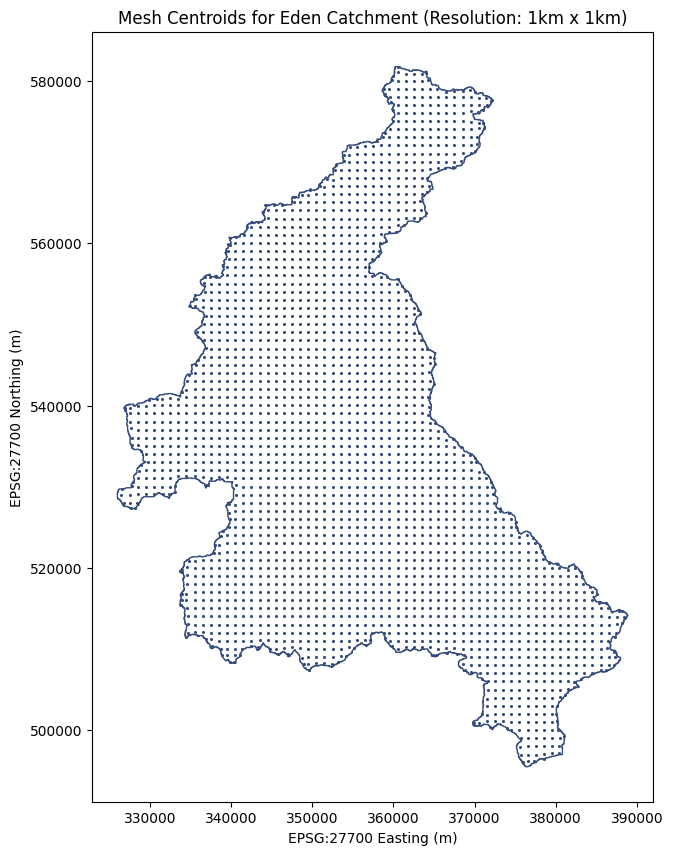

In [31]:
# Show map (select interactive vs static)
interactive = False
plot_interactive_mesh(mesh_nodes_gdf, catchment_polygon, interactive)

Basic matplotlib map

Import Station Data using DEFRA API

In [ ]:
# Use lookup file to create a dict of zipped grid letter and value lookup objects
grid_lookup_df = pd.read_csv("data/os_grid_squares.csv")
grid_letters = dict(zip(grid_lookup_df['grid_letters'], zip(grid_lookup_df['easting_base'], grid_lookup_df['northing_base'])))

# Transformer to WGS84 (for lat/long coordinate transformations)
transformer = Transformer.from_crs("epsg:27700", "epsg:4326", always_xy=True)

# Convert alphanumeric OS grid ref to easting, northing, lat, lon
def grid_ref_to_coords(grid_ref):
    
    # Clean grid references
    grid_ref = grid_ref.strip().upper()
    
    # Split to letter and numeric
    letter_only = grid_ref[:2]  # e.g. "NY" (from NY123456)
    numeric_only = grid_ref[2:]  # e.g. "123456" (from NY123456)
    
    # Check expected form (paired values)
    if len(numeric_only) % 2 != 0:
        raise ValueError(f"Invalid grid reference: {grid_ref}")
    
    easting_base, northing_base = grid_letters[letter_only]  # e.g. "300000, 500000" from NY (check ref file)
    half = len(numeric_only) // 2  # Seperate easting and northing (e.g. "123", "456")
    easting_offset = int(numeric_only[:half].ljust(5, '0'))  # e.g. "123" -> 12300 m
    northing_offset = int(numeric_only[half:].ljust(5, '0'))  # e.g. "456" -> 45600 m
    
    easting = easting_base + easting_offset  # e.g. 300000 + 12300 = 312300 m
    northing = northing_base + northing_offset  # e.g. 500000 + 45600 = 545600 m
    lon, lat = transformer.transform(easting, northing)  # Transform 312300, 545600 to lat, long (epsg:4326)
    
    return pd.Series([easting, northing, lat, lon])

# Apply to the station CSV
stations_df = pd.read_csv("data/station_list.csv")
stations_df[['easting', 'northing', 'lat', 'lon']] = stations_df['grid_ref'].apply(grid_ref_to_coords)

# Optional: Save and check
stations_df.to_csv("data/station_list_with_coords.csv", index=False)
print(stations_df.head())

Half: 4
Half: 4
Half: 4
Half: 4
Half: 4
Half: 4
Half: 4
Half: 5
Half: 4
Half: 4
Half: 5
Half: 4
Half: 4
Half: 4
Half: 4
  station_id    grid_ref   easting  northing        lat       lon
0     NY36_2  NY39146790  339140.0  567900.0  55.001931 -2.952971
1     NY46_3  NY46526426  346520.0  564260.0  54.970074 -2.836931
2    NY55_71  NY53825337  353820.0  553370.0  54.872953 -2.721158
3    NY54_54  NY56354839  356350.0  548390.0  54.828432 -2.680981
4    NY54_56  NY51774289  351770.0  542890.0  54.778590 -2.751349


In [7]:
import requests

base_url = "https://environment.data.gov.uk/hydrology/id/stations"

def get_station_metadata(wiski_id):
    params = {'wiskiID': wiski_id}
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data['items']:
            return data['items'][0]  # Assuming the first item is the desired station
    return None

# e.g.:
stations_df['metadata'] = stations_df['station_id'].apply(get_station_metadata)


In [8]:
def get_measures(station_uri):
    response = requests.get(f"{station_uri}/measures")
    if response.status_code == 200:
        return response.json()['items']
    return []

# e.g.:
stations_df['measures'] = stations_df['metadata'].apply(lambda x: get_measures(x['@id']) if x else [])

In [ ]:
import requests
import os
import pandas as pd
from datetime import datetime, timedelta

def download_readings(measure_uri, start_date_str, end_date_str, max_readings_per_request=50000):
    """
    Attempts to download readings for a measure using _limit, then filters by date.
    This works around issues with 'startdate'/'enddate' parameters on the EA API.
    """
    all_readings_dfs = []
    offset = 0 # For potential future pagination if _limit isn't enough
    
    # Define the actual desired date range for post-filtering
    desired_start_dt = datetime.strptime(start_date_str, '%Y-%m-%d')
    desired_end_dt = datetime.strptime(end_date_str, '%Y-%m-%d')

    print(f"  Attempting to fetch {measure_uri.split('/')[-1]} using _limit, then filtering from {start_date_str} to {end_date_str}")

    while True: # Loop to potentially handle pagination if needed
        params = {'_limit': max_readings_per_request,'_offset': offset}  # For pagination, starting from 0
        response = requests.get(f"{measure_uri}/readings", params=params)

        if response.status_code == 200:
            readings = response.json().get('items', [])
            if readings:
                df = pd.DataFrame(readings)
                all_readings_dfs.append(df)
                
                # Check if the max_readings_per_request was received indicating more data might exist
                if len(readings) < max_readings_per_request:
                    break # No more data to fetch for this measure
                else:
                    offset += max_readings_per_request # Move offset for next chunk
            else:
                break # No readings in this chunk, so no more data
        else:
            print(f"    Failed to fetch readings for: {measure_uri.split('/')[-1]} — Status: {response.status_code}")
            print(f"    Request URL: {response.url}")
            print(f"    Response Content: {response.text}")
            break # Exit loop (error or no readings)

    if all_readings_dfs:
        combined_df = pd.concat(all_readings_dfs, ignore_index=True)
        combined_df.drop_duplicates(subset=['dateTime', 'value'], inplace=True) # Remove potential duplicates

        # Convert dateTime to datetime objects for filtering
        combined_df['dateTime'] = pd.to_datetime(combined_df['dateTime'])
        
        # Filter by the desired date range in Pandas
        filtered_df = combined_df[
            (combined_df['dateTime'] >= desired_start_dt) & 
            (combined_df['dateTime'] <= desired_end_dt)
        ].copy() # Use .copy() to avoid SettingWithCopyWarning

        if not filtered_df.empty:
            os.makedirs("data/gwl", exist_ok=True)
            filename = f"data/gwl/{measure_uri.split('/')[-1]}_readings.csv"
            filtered_df.to_csv(filename, index=False)
            print(f"    Saved {len(filtered_df)} filtered readings to: {filename}")
            return filtered_df
        else:
            print(f"    No readings found within the specified date range ({start_date_str} to {end_date_str}) for {measure_uri.split('/')[-1]}.")
    
    else:
        print(f"    No total readings retrieved for: {measure_uri.split('/')[-1]}.")
    
    return None

# Main loop for downloading readings
for index, row in stations_df.iterrows():
    for measure in row['measures']:
        obs_prop = measure.get('observedProperty', {}).get('@id', '')
        if 'groundwaterLevel' in obs_prop:
            print(f"\nProcessing measure: {measure['@id'].split('/')[-1]}")
            # Use the full date range for downloading and filtering
            df_readings = download_readings(measure['@id'], '2014-01-01', '2025-01-01', max_readings_per_request=50000)


Processing measure: 6257f7cc-f392-4a98-814a-1d8f20e3fadd-gw-logged-i-subdaily-mAOD-qualified
  Attempting to fetch 6257f7cc-f392-4a98-814a-1d8f20e3fadd-gw-logged-i-subdaily-mAOD-qualified using _limit, then filtering from 2014-01-01 to 2025-01-01
    Saved 95680 filtered readings to: data/gwl/6257f7cc-f392-4a98-814a-1d8f20e3fadd-gw-logged-i-subdaily-mAOD-qualified_readings.csv

Processing measure: dbdc1aca-14eb-45e8-beb5-204d5e5f9133-gw-logged-i-subdaily-mAOD-qualified
  Attempting to fetch dbdc1aca-14eb-45e8-beb5-204d5e5f9133-gw-logged-i-subdaily-mAOD-qualified using _limit, then filtering from 2014-01-01 to 2025-01-01
    Saved 95641 filtered readings to: data/gwl/dbdc1aca-14eb-45e8-beb5-204d5e5f9133-gw-logged-i-subdaily-mAOD-qualified_readings.csv

Processing measure: b1fe9623-1084-4d26-8259-7fea24ee0718-gw-logged-i-subdaily-mAOD-qualified
  Attempting to fetch b1fe9623-1084-4d26-8259-7fea24ee0718-gw-logged-i-subdaily-mAOD-qualified using _limit, then filtering from 2014-01-01 to 2


Data from data/gwl/6257f7cc-f392-4a98-814a-1d8f20e3fadd-gw-logged-i-subdaily-mAOD-qualified_readings.csv...

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95680 entries, 2014-01-01 01:35:00 to 2025-01-01 00:00:00
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   measure  95680 non-null  object 
 1   date     95680 non-null  object 
 2   value    95318 non-null  float64
 3   quality  95680 non-null  object 
 4   qcode    176 non-null    object 
dtypes: float64(1), object(4)
memory usage: 4.4+ MB


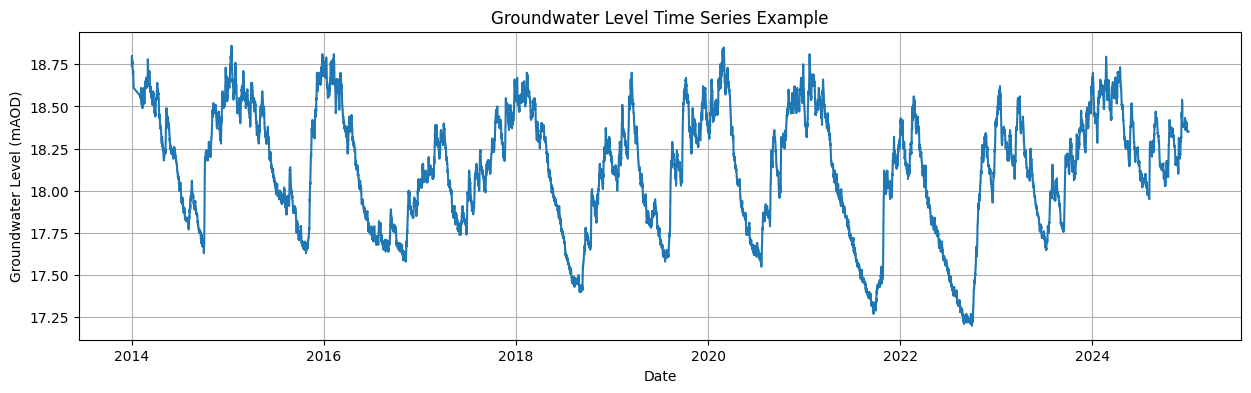


Data from data/gwl/6721b179-8dd2-4eb0-9c20-5bd3d89381c4-gw-logged-i-subdaily-mAOD-qualified_readings.csv...

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96433 entries, 2014-01-01 00:00:00 to 2025-01-01 00:00:00
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   measure  96433 non-null  object 
 1   date     96433 non-null  object 
 2   value    93207 non-null  float64
 3   quality  96433 non-null  object 
 4   qcode    664 non-null    object 
dtypes: float64(1), object(4)
memory usage: 4.4+ MB


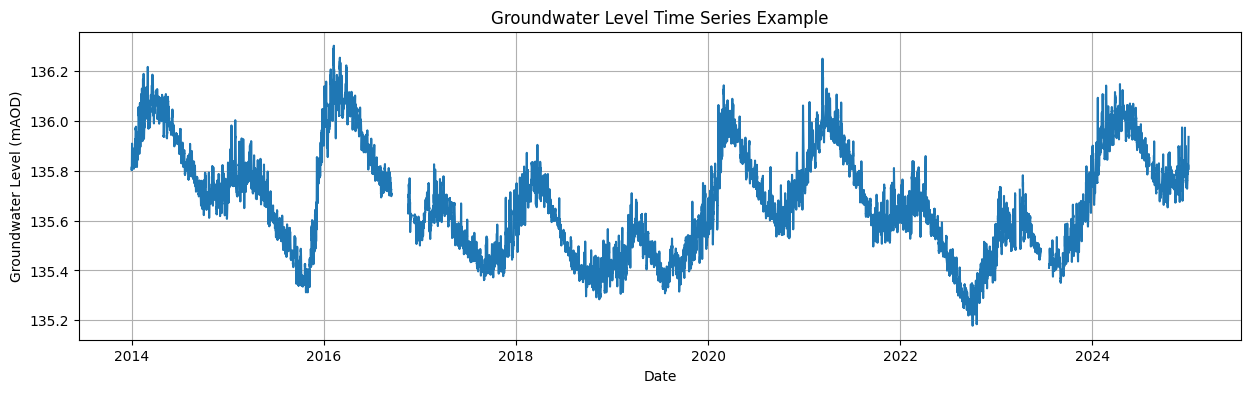

In [10]:
data_filename = ["data/gwl/6257f7cc-f392-4a98-814a-1d8f20e3fadd-gw-logged-i-subdaily-mAOD-qualified_readings.csv",
                 "data/gwl/6721b179-8dd2-4eb0-9c20-5bd3d89381c4-gw-logged-i-subdaily-mAOD-qualified_readings.csv"]

# Check if the file exists before trying to read it
for file in data_filename:
    if os.path.exists(file):
        
        # Load the CSV into a Pandas DataFrame
        df_ts = pd.read_csv(file)
        df_ts['dateTime'] = pd.to_datetime(df_ts['dateTime'])
        df_ts = df_ts.set_index('dateTime')

        # Display first few rows of the DataFrame
        print(f"\nData from {file}...\n")
        # print(df_ts.head())
        # print("\nDataFrame Info")
        df_ts.info()

        # Plot
        plt.figure(figsize=(15, 4))
        # plt.plot(df_ts['value'].head(1000)) # Plot first 1000 points for quick view
        plt.plot(df_ts['value'])
        plt.title('Groundwater Level Time Series Example')
        plt.xlabel('Date')
        plt.ylabel('Groundwater Level (mAOD)')
        plt.grid()
        plt.show()

    else:
        print(f"Error: File not found at {file}.")

Create geodataframes for stations:

In [ ]:
# from shapely.geometry import Point

# # Convert to GeoDataFrame using WGS84 (lat/lon)
# stations_gdf = gpd.GeoDataFrame(
#     stations_df,
#     geometry=gpd.points_from_xy(stations_df['lon'], stations_df['lat']),
#     crs="EPSG:4326"
# )

# # Reproject to match mesh CRS (British National Grid)
# stations_gdf = stations_gdf.to_crs("EPSG:27700")


Snap stations to nearest mesh node

In [ ]:
# from shapely.ops import nearest_points
# import shapely.geometry

# # Rebuild mesh index
# mesh_sindex = mesh_nodes_gdf.sindex

# def find_nearest_node(station_point):
#     # This is the key fix: pass geometry directly, not as a list
#     nearest_idx = list(mesh_sindex.nearest(station_point, return_all=False))[0]

#     nearest_row = mesh_nodes_gdf.iloc[nearest_idx]
#     nearest_geom = nearest_row.geometry

#     # Ensure it's a proper Shapely Point
#     if hasattr(nearest_geom, '__geo_interface__') and not isinstance(nearest_geom, shapely.geometry.base.BaseGeometry):
#         nearest_geom = shapely.geometry.shape(nearest_geom)

#     return pd.Series({
#         'nearest_node_id': int(nearest_row['node_id']),
#         'nearest_geometry': nearest_geom
#     })


# # Apply snapping
# stations_gdf[['nearest_node_id', 'nearest_geometry']] = stations_gdf.geometry.apply(find_nearest_node)
# stations_gdf = stations_gdf.set_geometry('nearest_geometry').to_crs("EPSG:4326")
# stations_gdf['lat'] = stations_gdf.geometry.y
# stations_gdf['lon'] = stations_gdf.geometry.x


GeometryTypeError: Unknown geometry type: 'featurecollection'

In [ ]:
print(stations_gdf[['station_id', 'nearest_node_id', 'lat', 'lon']])

In [ ]:
import folium

# Recreate map centered on catchment
map_center = [mesh_nodes_gdf['lat'].mean(), mesh_nodes_gdf['lon'].mean()]
map = folium.Map(location=map_center, zoom_start=10, tiles="CartoDB positron")

# Add snapped station locations
for _, row in stations_gdf.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f"{row['station_id']} → Node {row['nearest_node_id']}"
    ).add_to(map)

# Optionally add mesh nodes
for _, row in mesh_nodes_gdf.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=1,
        color="#354c7c",
        fill=True,
        fill_opacity=0.6
    ).add_to(map)

# Save
map.save("figures/station_to_mesh_snapping.html")
map


In [ ]:
print(stations_gdf[['station_id', 'nearest_node_id', 'geometry']])
print(stations_gdf.crs)
